The cell below installs the required Python packages for this notebook.

In [42]:
%pip install sklearn pandas numpy kaggle aif360

## Imports

In [1]:
# Scikit-learn
from sklearn.datasets import fetch_california_housing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPRegressor

# aif360
from aif360.datasets import BinaryLabelDataset
from aif360.sklearn.postprocessing import PostProcessingMeta, RejectOptionClassifier, RejectOptionClassifierCV

# Data manipulation and math
import pandas as pd
import numpy as np
from scipy.stats import randint, gamma, chi2_contingency, spearmanr
from zipfile import ZipFile

# Visualization
import matplotlib.pyplot as plt
from matplotlib import tri

# Supress FutureWarning due to aif360
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pip install 'aif360[LawSchoolGPA]'


# How can the statistical parity fairness notions be satisfied, and how does affect the performance of a machine learning model?
For this research question, we will explore what different approaches are to help satisfy the statistical parity fairness notion. We will look how fairness can be quantified and how it affects the performance of a machine learning model. First, we motivate this research questions by contextualizing the relevance of fairness in machine learning. We briefly introduce fairness and statistical parity. Then, we attempt to satisfy the fairness notion and assess its fairness and performance on a model.

## Motivation
Machine learning applications are increasingly being applied in the industry. Legislators, insurers and banks are playing catch-up to integrate this technology in the process of decision-making. Supervised learning often relies on historical data. This means that bias present in the data is transferred to the model. Perpetuating this bias is not only unfair, but often unlawful or contrary to company policy. Chouldechova & Roth (2018) identify three possible causes of unfairness:
* **Bias in training data**: historical data that has human bias embedded in it. A classic example is the disproportionate amount of crime committed by some marginalized and ostracized communities. However, this can often be explained by considering the socio-economic situation. Also, these areas might be policed at a higher rate, which further skews crime-prediction models.
* **Minimizing average error**: a majority group will be more accurately represented in a model than a minority group. Naturally, it follows from the fact that the majority group has a larger representation and thus minimizing errors will benefit more if the error of each individual has the same weight.
* **Related to exploration**: online learning models that gets updated with new information while being used, can greatly benefit from the information gained of taking suboptimal decisions. This can be either amoral (e.g. for medical procedures) or benefit/disadvantage certain groups.

Different fairness notions have been introduced in the literature to mitigate problems like these. Knowing which notion to satisfy, depends on the problem and fairness goals.

## Fairness
There is three fairness criteria (Barocas et al., 2017):
* **Independence** $S \bot R$: sensitive features $S$ need to be independent to the scoring metric $R$.
* **Separation** $S \bot R \mid Y$: sensitive features need to be conditionally independent to the scoring metric, given the target variable $Y$.
* **Sufficiency** $S \bot Y \mid R$: sensitive features need to be conditionally independent to the target variable, given the scoring metric.

In general, it is not always possible to satisfy all three criteria. A fairness notion is a statistical property that a learned model can satisfy. When it does, the model is fair with respect to that fairness notion. These notions usually address one of the above criteria. 

Methods that help models satisfy fairness notions can be classified in three groups (Chzhen, 2022):
- **Preprocessing**: methods that transform the training dataset into a more fair representation.
- **Inprocessing**: methods that contribute to fairness during the training procedure.
- **Postprocessing**: methods that increase fairness by means of changing predictions of a model.

We will now introduce statistical parity.

### Statistical parity
There exists different group fairness notions (see Barocas et al., 2017 for an extensive list). Group fairness notions address fairness with respect to a protected group of a sensitive feature. In this work, we only consider **statistical parity** (also known as demographic parity). It is satisfied for a given protected group attribute when the *positive* classification distribution is to the other groups of the sensitive feature (Barocas et al., 2017). This means that predictions need to be statistically independent with respect to the sensitive feature. It means that it addresses the independence fairness criteria. For a sensitive attribute $S$ (with $p$ a protected subgroup) and a binary classifier $\hat{Y}$ (with $+$ deemed a *positive* prediction) from dataset $X$, it must hold that for samples $\vec{x} \in X$:
$$\mathbb{P}(\vec{x}(\hat{Y}) = + \mid \vec{x}(S) = p) = \mathbb{P}(\vec{x}(\hat{Y}) = + \mid \vec{x}(S) \ne p)$$

The supervised learning problem is transformed in a multiobjective optimization problem. The two optimization goals become:
* Minimizing the dependency between $S = p$ and $\hat{Y}$.
* Maximizing the accuracy of predictions $Y$.

A way of quantifying the dependency was proposed by Calders et al. (2009). It corresponds to taking the difference in positive prediction rates of both groups on a dataset $X$:
$$\operatorname{dep}_{S=p}(X) := \frac {|\{\vec{x} \in X \mid \vec{x}(S) \ne p, \vec{x}(\hat{Y}) = +\}|} {|\{\vec{x} \in X \mid \vec{x}(S) \ne p\}|} - \frac {|\{\vec{x} \in X \mid \vec{x}(S) = p, \vec{x}(\hat{Y}) = +\}|} {|\{\vec{x} \in X \mid \vec{x}(S) = p\}|}$$

This metric is also called the statistical parity difference.

## Naive fairness through unawareness
In the first problem we will adapt the dependency metric to a regression problem. The approach to improving fairness we employ here will not be effective. However, the way we quantify the dependence is still useful in context of regression problems.

### California housing value dataset

The first dataset used for this research question deals with a regression problem. It requires estimation of the median house value for California house districts (Pace & Barry, 1997). We will try to satisfy statistical parity. In regression problems we can substitute groups and classification by thresholds (Agarwal et al., 2019). An example use case for a model trained on this data could be as guideline for regulating house prices. In turn this could help solve problems such as gentrification by limiting house prices. Below, we fetch the dataset and show the first 10 entries.

In [2]:
housing_df = fetch_california_housing(as_frame=True).frame
housing_df.head(10)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
5,4.0368,52.0,4.761658,1.103627,413.0,2.139896,37.85,-122.25,2.697
6,3.6591,52.0,4.931907,0.951362,1094.0,2.128405,37.84,-122.25,2.992
7,3.1200,52.0,4.797527,1.061824,1157.0,1.788253,37.84,-122.25,2.414
8,2.0804,42.0,4.294118,1.117647,1206.0,2.026891,37.84,-122.26,2.267
9,3.6912,52.0,4.970588,0.990196,1551.0,2.172269,37.84,-122.25,2.611


All features are numerical. Analyzing the correlation between the median house value and the other features might give insight into which features impact the house value. In some cases this might be due to bias. We plot the pairwise feature correlations using a heatmap.

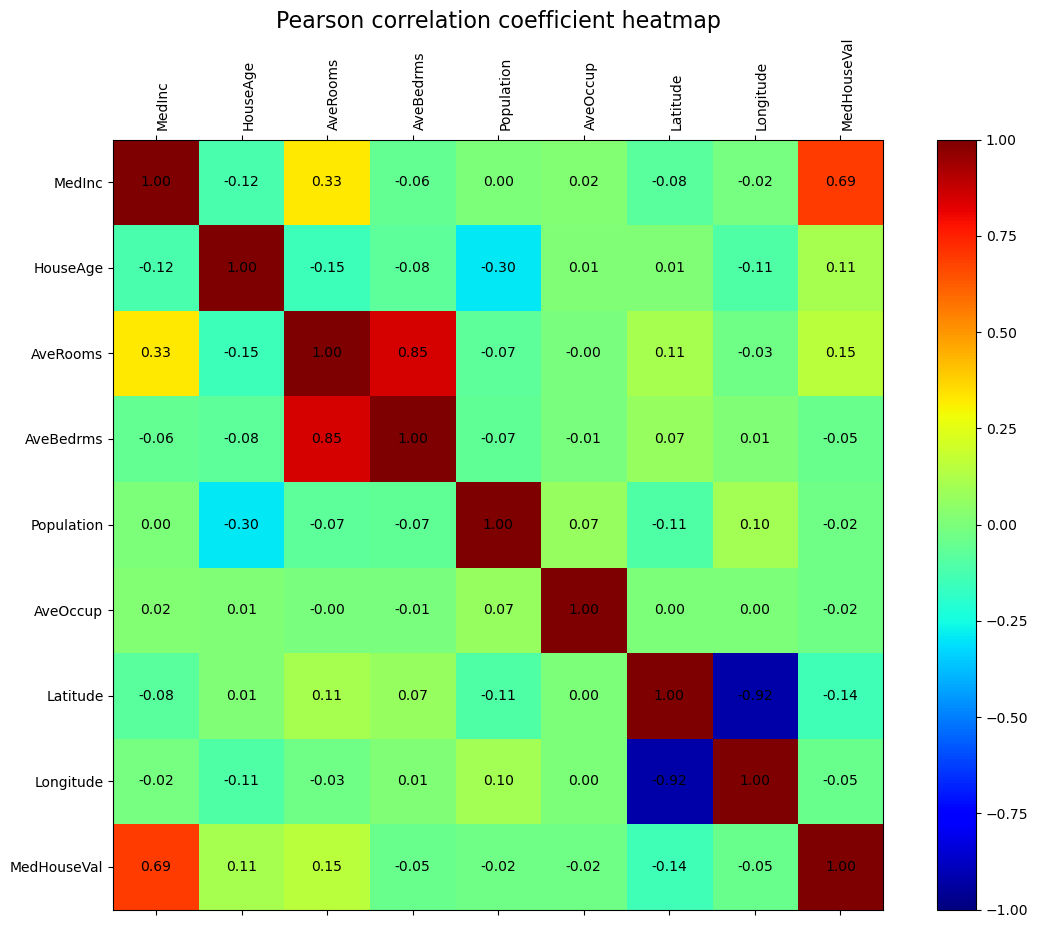

In [3]:
# calculate pearson coefficient matrix
corr = np.corrcoef(housing_df, rowvar=False)

# Show heat map
fig, ax = plt.subplots(figsize=(14,10))
plt.jet()

cax = ax.matshow(corr, vmin=-1, vmax=1)
fig.colorbar(cax)

for (i, j), c in np.ndenumerate(corr):
    ax.text(j, i, f'{c:.2f}', ha='center', va='center')

ax.set_title('Pearson correlation coefficient heatmap', fontsize=16, wrap=True)
ticks = list(range(len(housing_df.columns)))
ax.set_xticks(ticks)
ax.set_yticks(ticks)

ax.set_xticklabels(housing_df.columns, rotation=90, horizontalalignment='left')
ax.set_yticklabels(housing_df.columns)
plt.show()

Most features do not seem to correlate with each other. Interestingly, the median income of the district has a high correlation with its median house value. Correlation implies dependence. The heatmap displays the Pearson correlation which check a linear relationship. A more appropriate correlation coefficient is the Spearman correlation because is generalized to a monotonic relationship. To check for significant positive monotonic correlation between median district income and median house value we perform a Spearman correlation statistical test, i.e. $\operatorname{H}_0: \rho \le 0$ (no correlation) and $\operatorname{H}_A: \rho \gt 0$ on significance level $\alpha = 0.05$:

In [4]:
income_spearman_res = spearmanr(housing_df[['MedInc', 'MedHouseVal']], alternative='greater')
print(f'INCOME \ HOUSEVAL: r = {income_spearman_res.statistic:.2f}; p = {income_spearman_res.pvalue}; N = {len(housing_df)}; df = {len(housing_df) - 2}')

INCOME \ HOUSEVAL: r = 0.68; p = 0.0; N = 20640; df = 20638


The test indicates a statistical significant positive monotonic correlation between median income and median house value (of districts in California), $\rho(20640) = 0.68$; $p < 0.01$. This likely is the result of expensive districts attracting upper-class families, while less attractive districts are left to lower-class families. For the sake of this research question, we assume that this is undesired bias (to some extent). This could possibly be the result of gentrification. We show a scatter plot to visualize the relation:

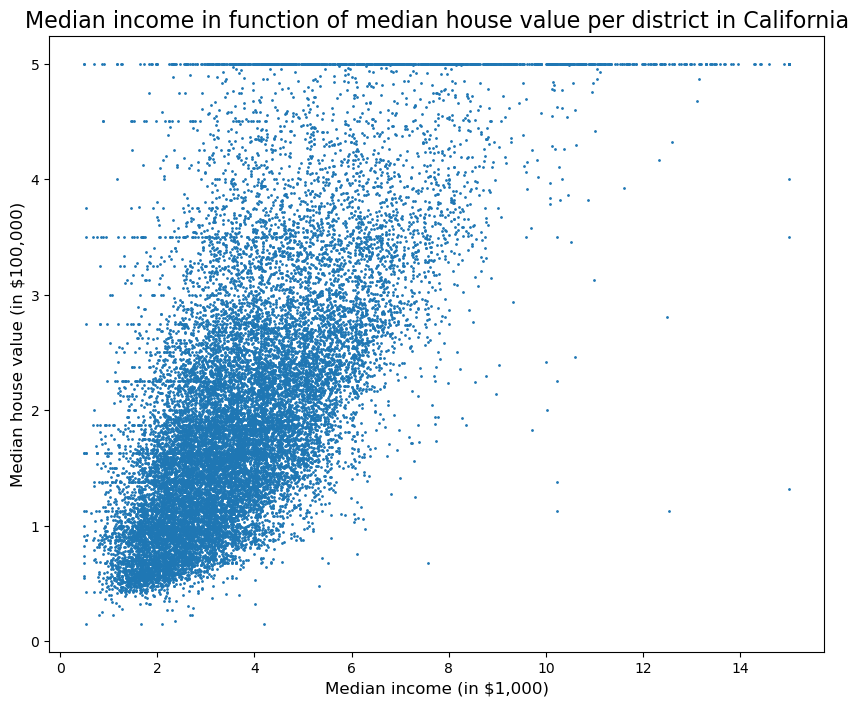

In [38]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(housing_df['MedInc'], housing_df['MedHouseVal'], s=1)
ax.set_title('Median income in function of median house value per district in California', fontsize=16, wrap=True)
ax.set_xlabel('Median income (in $1,000)', fontsize=12)
ax.set_ylabel(f'Median house value (in $100,000)', fontsize=12)

plt.show()

Therefore, we choose median income as sensitive feature. Districts that have a median income that is below the median (of the medians) are designated as protected group, and above median (of the medians) house value is considered a positive *classification*.

Note: Generally protected groups are chosen before looking at the data, usually by following ethical guidelines. Otherwise, we can introduce bias ourselves. Here, we do it to be sure we select a disadvantaged group for the sake of example.

We show a plot to compare protected to unprotected groups and calculate the dependence metric $\operatorname{dep}_{\mathrm{AboveMedInc} = 0}$.

In [6]:
# gets the rate of positive classifications of each sensitive subgroup
def sensitive_rate_df(df_x, df_y, positive):
    df = pd.DataFrame({
        'x': df_x.reset_index(drop=True),
        'y': df_y.reset_index(drop=True)
    })
    return df.groupby('x') \
             .agg(
                 TotalCount=('y', len),
                 Proportion=('y', lambda g: len(g) / len(df)),
                 PositiveCount=('y', lambda g: g.value_counts()[positive]),
                 PositiveRate=('y', lambda g: g.value_counts()[positive] / len(g))
             )

# plots the positive classification reate of each sensitive subgroup
def sensitive_rate_plots(df_xs, df_ys, positives, titles):
    fig, axs = plt.subplots(1, len(titles), figsize=(6.4 * len(titles), 4.8))
    axs = np.atleast_1d(axs)

    for ax, df_x, df_y, positive, title in zip(axs, df_xs, df_ys, positives, titles):
        avg_pos = (df_y == positive).sum() / len(df_y)
        sens_rate = sensitive_rate_df(df_x, df_y, positive)

        bars = ax.bar(sens_rate.index, sens_rate['PositiveRate'])

        ax.bar_label(bars, labels=sens_rate['PositiveCount'])

        ax.set_title(f'{title}, (N = {len(df_x)})', fontsize=16, wrap=True)
        ax.set_xlabel(df_x.name, fontsize=12)
        ax.set_xticks(df_x.unique())
        ax.set_ylabel(f'{df_y.name} rate', fontsize=12)
        ax.axhline(y=avg_pos, linewidth=1, linestyle=':', color='r', label='Overall rate')
        ax.annotate(
            f'{avg_pos:.2f}', 
            xy=(1, avg_pos), 
            xytext=(10, 0),
            xycoords=('axes fraction', 'data'),
            textcoords='offset points',
            va='center',
            color='r'
        )
        ax.legend(loc='lower right')
        
    fig.tight_layout()
    plt.show()

Therefore, we choose median income as sensitive feature. Districts that have a median income that is below the median (of the medians) are designated as protected group, and above median (of the medians) house value is considered a positive *classification*.

Note: In general, protected groups are chosen before looking at the data, usually by following ethical guidelines. Otherwise, we can introduce bias ourselves. Here, we do it to be sure we select a disadvantaged group for the sake of example.

We show a plot to compare protected to unprotected groups and calculate the dependence metric $\operatorname{dep}_{\mathrm{AboveMedInc} = 0}$.

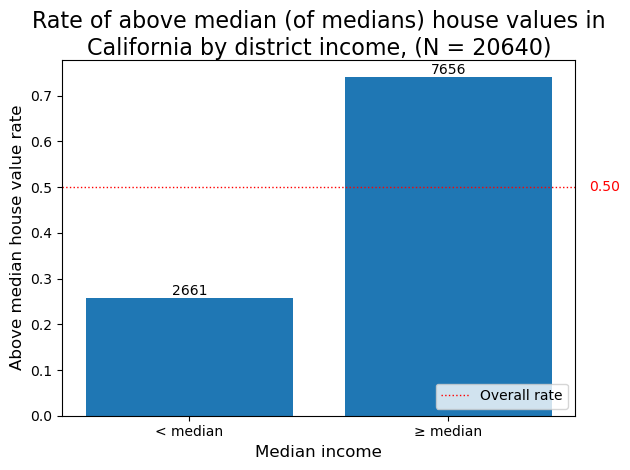

In [7]:
# get protected group
housing_inc_med = housing_df['MedInc'].median()
housing_prot_mask = (housing_df['MedInc'] < housing_inc_med).astype(int)
housing_prot_desc = pd.Series(housing_prot_mask.replace({1: '< median', 0: '≥ median'}), name='Median income')

# get positive classified group
housing_inc_med = housing_df['MedHouseVal'].median()
housing_inc_mask = (housing_df['MedHouseVal'] > housing_inc_med).astype(int)
housing_inc = pd.Series(housing_inc_mask, name='Above median house value')

sensitive_rate_plots(
    [housing_prot_desc],
    [housing_inc],
    [1],
    ['Rate of above median (of medians) house values in California by district income'],
)

In [8]:
# calculates the dependence metric for statistical parity
def fairness_dependence_metric(df_x, df_y, protected_group, positive):
    prot_mask = df_x == protected_group
    pos_mask = df_y == positive

    n_prot = prot_mask.sum()
    n_prot_pos = (prot_mask & pos_mask).sum()

    n_nprot = (~prot_mask).sum()
    n_nprot_pos = (~prot_mask & pos_mask).sum()

    return (n_nprot_pos / n_nprot) - (n_prot_pos / n_prot)

In [9]:
dep_latino = fairness_dependence_metric(
    housing_prot_mask,
    housing_inc_mask,
    1,
    1,
)

print(f'DEP: {dep_latino:.2f}')

DEP: 0.48


Both the plot and the fairness dependence metric show unfairness with respect to statistical parity.

### Preprocessing
The first attempt of increasing fairness involves removing the sensitive feature. It is a preprocessing method that is called **fairness through unawareness**. So in this step, we drop the sensitive feature (median income). We also use a standard scaler to improve performance. Finally, we split the dataset in a train and test set. Eventually we only keep the $k$-best parameters based on the F-statistic, which is recommended.

In [10]:
# input features / target split
housing_y = housing_df['MedHouseVal']
housing_X = housing_df.drop(['MedHouseVal', 'MedInc'], axis=1) # drop target and sensitive feature

housing_scale = StandardScaler()

# training / test split
(
    housing_X_train,
    housing_X_test,
    housing_y_train,
    housing_y_test,
    housing_i_train,
    housing_i_test,
) = train_test_split(
    housing_X, 
    housing_y,
    np.arange(len(housing_df)),
    test_size=0.25,
    random_state=0,
    shuffle=True
)

# select k-best parameters based on F-test
housing_skb = SelectKBest(f_regression)

### Model fitting and hyperparameter search
We proceed with fitting a multi-layer perceptron to the training data. We select the best hyperparameters using randomized grid search with 5-fold cross-validation with MAE to measure performance.

In [11]:
# pipeline with preprocessing and MLP
housing_pipe = Pipeline([
    ('col_standard', housing_scale),
    ('k_best', housing_skb),
    ('mlpr', MLPRegressor(
        max_iter=10000,
        random_state=0))
])

# hyperparameters
housing_params = {
    'k_best__k': randint(5, len(housing_X_train.columns)), # k-best features
    'mlpr__hidden_layer_sizes': [ # hidden layer layout
        (5,), (8,), (10,), (15,),
        (5, 5), (5, 8,), (8, 8), (8, 5), (10, 10), (5, 10), (10, 5)
     ],
    'mlpr__activation': ['identity', 'logistic', 'tanh', 'relu'], # activation function
    'mlpr__alpha': gamma(2, scale=0.001) # learning rate
}

# 5-fold cross-validation
housing_kfcv = KFold(n_splits=5)

# grid search for best parameters
housing_mlpr_rcv = RandomizedSearchCV(
    housing_pipe, 
    housing_params,
    n_iter=50,
    scoring='neg_mean_absolute_error',
    refit=True,
    n_jobs=-1,
    cv=housing_kfcv,
    random_state=0,
    return_train_score=True
)

# fit and print best params
housing_mlpr_rcv.fit(housing_X_train, housing_y_train)
for param, value in housing_mlpr_rcv.best_params_.items():
    print(f'{param}: {value}')

k_best__k: 6
mlpr__activation: tanh
mlpr__alpha: 0.0009505816689836764
mlpr__hidden_layer_sizes: (10, 10)


### Model performance and fairness assessment
Now that the model is fitted, we assess its performance on the test set.

In [12]:
# prints basic performance metrics
def score_summary(y_test, y_pred):
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    print(f'R^2: {r2:.2f}; MAE: {mae:.2f}; MSE: {mse:.2f}')

In [13]:
housing_y_test_pred = housing_mlpr_rcv.predict(housing_X_test)
score_summary(housing_y_test_pred, housing_y_test)

R^2: 0.66; MAE: 0.40; MSE: 0.34


The mean absolute error of this model with acceptable bounds. We continue with assessing the fairness as this is another main concern.

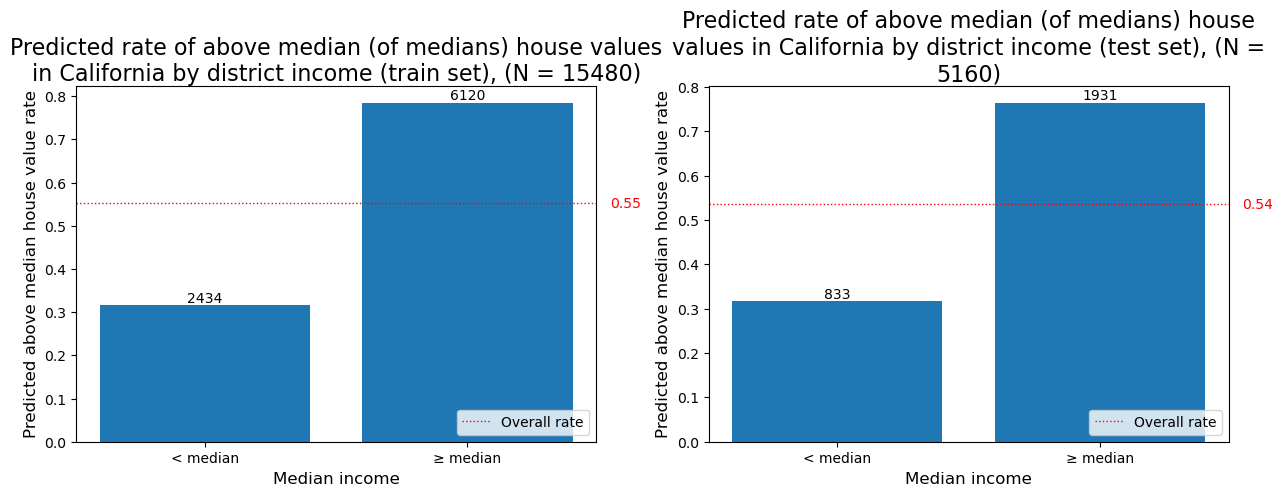

In [14]:
housing_y_train_pred = housing_mlpr_rcv.predict(housing_X_train)

# get protected group
housing_prot_mask_train = housing_prot_mask[housing_i_train]
housing_prot_desc_train = housing_prot_desc[housing_i_train]
housing_prot_mask_test = housing_prot_mask[housing_i_test]
housing_prot_desc_test = housing_prot_desc[housing_i_test]

# get positive classified group
housing_inc_mask_train = (housing_y_train_pred > housing_inc_med).astype(int)
housing_inc_train = pd.Series(housing_inc_mask_train, name='Predicted above median house value')
housing_inc_mask_test = (housing_y_test_pred > housing_inc_med).astype(int)
housing_inc_test = pd.Series(housing_inc_mask_test, name='Predicted above median house value')

sensitive_rate_plots(
    [housing_prot_desc_train, housing_prot_desc_test],
    [housing_inc_train, housing_inc_test],
    [1, 1],
    ['Predicted rate of above median (of medians) house values in California by district income (train set)', 'Predicted rate of above median (of medians) house values in California by district income (test set)'],
)

In [15]:
dep_prot_train = fairness_dependence_metric(
    housing_prot_mask_train,
    housing_inc_mask_train,
    1,
    1,
)

dep_prot_train = fairness_dependence_metric(
    housing_prot_mask_test,
    housing_inc_mask_test,
    1,
    1,
)

print(f'DEP on train: {dep_prot_train:.2f}; DEP on test: {dep_prot_train:.2f}')

DEP on train: 0.45; DEP on test: 0.45


The dependence did not decrease. Fairness through unawareness does generally not lead to satisfying this fairness notion. Moreover, there often exist (a combination of) proxies for the sensitive feature. Here, proxies could include a combination of longitude and latitude. The multi-layer perceptron could learn the non-linear relation that helps identify rich districts.

## Baseline classifier without fairness
We continue to a different problem on classification. The reason is that most literature on fairness is for classification problems. In this section we train a Gaussian naive Bayes Classifier on the dataset without any regard for fairness. The Gaussian naive Bayes model is chosen because of its simplicity and efficiency. But, it is also one of the Scikit-learn models that support sample reweighing which is used in the next section.

### Credit card approval
The dataset for the classification problem is on credit card approval of customers (Dua & Graff 2019). It has already been cleaned, and missing values have been filled (potentially contributing to any bias). The sensitive features include ethnicity and gender. We use this dataset to satisfy statistical parity. We download the dataset, loads it and shows the first 10 entries.

In [16]:
!kaggle datasets download -p data samuelcortinhas/credit-card-approval-clean-data

credit_zip = ZipFile('data/credit-card-approval-clean-data.zip')
credit_df = pd.read_csv(credit_zip.open('clean_dataset.csv'))
credit_df.head(10)

credit-card-approval-clean-data.zip: Skipping, found more recently modified local copy (use --force to force download)


,Gender,Age,Debt,Married,BankCustomer,Industry,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,ZipCode,Income,Approved
0,1,30.83,0.000,1,1,Industrials,White,1.250,1,1,1,0,ByBirth,202,0,1
1,0,58.67,4.460,1,1,Materials,Black,3.040,1,1,6,0,ByBirth,43,560,1
2,0,24.50,0.500,1,1,Materials,Black,1.500,1,0,0,0,ByBirth,280,824,1
3,1,27.83,1.540,1,1,Industrials,White,3.750,1,1,5,1,ByBirth,100,3,1
4,1,20.17,5.625,1,1,Industrials,White,1.710,1,0,0,0,ByOtherMeans,120,0,1
5,1,32.08,4.000,1,1,CommunicationServices,White,2.500,1,0,0,1,ByBirth,360,0,1
6,1,33.17,1.040,1,1,Transport,Black,6.500,1,0,0,1,ByBirth,164,31285,1
7,0,22.92,11.585,1,1,InformationTechnology,White,0.040,1,0,0,0,ByBirth,80,1349,1
8,1,54.42,0.500,0,0,Financials,Black,3.960,1,0,0,0,ByBirth,180,314,1
9,1,42.50,4.915,0,0,Industrials,White,3.165,1,0,0,1,ByBirth,52,1442,1


The approval rates for the different genders and ethnicities are interesting properties, as these are considered sensitive features in society. The rate of each sensitive feature with the overall rate is visualized using a bar charts below. Each subgroup has the count of the approved group members on top of the bar.

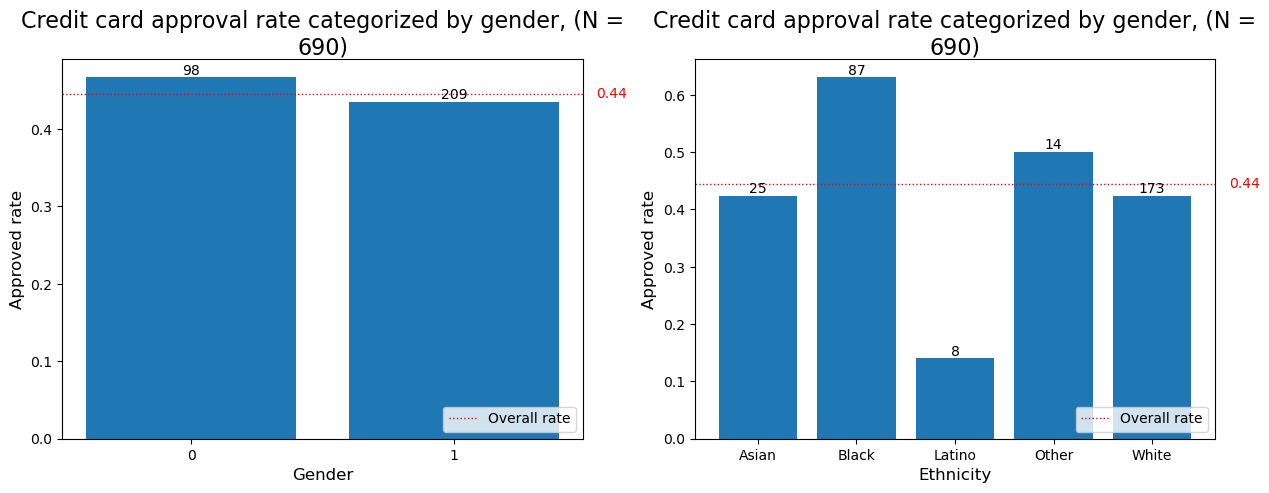

In [17]:
sensitive_rate_plots(
    [credit_df['Gender'], credit_df['Ethnicity']],
    [credit_df['Approved'], credit_df['Approved']],
    [1, 1],
    ['Credit card approval rate categorized by gender', 'Credit card approval rate categorized by gender'],
)

We clearly see that approval rates are not consistent across groups, especially for ethnicity. We perform a $\chi^2$-test to test for dependence ($H_A$) with significance level $\alpha = 0.05$, both between gender and approval, and ethnicity and approval.

In [18]:
gender_contingency = pd.crosstab(index=credit_df['Gender'], columns=credit_df['Approved'])
gender_chi2_res = chi2_contingency(gender_contingency)
print(f'GENDER: X^2 = {gender_chi2_res.statistic:.2f}; p = {gender_chi2_res.pvalue:.2}; N = {len(credit_df)}; df = {gender_chi2_res.dof}')

ethnicity_contingency = pd.crosstab(index=credit_df['Ethnicity'], columns=credit_df['Approved'])
ethnicity_chi2_res = chi2_contingency(ethnicity_contingency)
print(f'ETHNICITY: X^2 = {ethnicity_chi2_res.statistic:.2f}; p = {ethnicity_chi2_res.pvalue:.2}; N = {len(credit_df)}; df = {ethnicity_chi2_res.dof}')

GENDER: X^2 = 0.46; p = 0.5; N = 690; df = 1
ETHNICITY: X^2 = 41.81; p = 1.8e-08; N = 690; df = 4


The first test indicates that there is no indication of dependence between gender and approval ($H_0$ not rejected), $\chi^2(1, 690) = 0.5$; $p = 0.5$.
There is a statistical significant relationship between ethnicity of a customer and their credit card approval, $\chi^2(4, 690) = 41.8$; $p < 0.001$. This could be an indication of bias in the training set. Regardless of bias, statistical parity aims to remove the dependency of a sensitive feature.
We choose ethnicity as sensitive feature for satisfying statistical parity, and Latinos as protected group.

Note: Because the test failed to indicate there is dependence between gender and approval, it does not prove independence. Moreover, statistical parity is a property of the predictive model, but we only looked at dependence in the dataset. Therefore, satisfying statistical parity for gender could also be a requirement. Here, we choose to only satisfy this fairness notion with respect to ethnicity for simplicity.

Calculating the dependence metric $\operatorname{dep}_{E = \mathrm{Latino}}$:

In [19]:
dep_latino = fairness_dependence_metric(
    credit_df['Ethnicity'],
    credit_df['Approved'],
    'Latino',
    1
)

print(f'DEP: {dep_latino:.2f}')

DEP: 0.33


### Preprocessing
We start by performing preprocessing on the dataset. The Gaussian naive Bayes works best on normal distributed data. Therefore, we perform a transformation to standardize the features. Nominal categories are one-hot encoded using dummy columns for each possible category. Eventually we only keep the $k$-best features based on the F-statistic, which is recommended. The data is transformed using the above defined preprocessing. It is then split the dataset into training and test set. We use a stratification scheme that ensures a proportional representation of the target feature (approval) in the resulting test and training set.

In [20]:
# appropriate preprocessing on each feature
credit_nom = (
    'encode_nominals',
    OneHotEncoder(), # create dummy features
    ['Ethnicity', 'Industry', 'Citizen']
)
credit_std = (
    'standard_scale',
    StandardScaler(), # standardize data
    ['Age', 'Debt', 'YearsEmployed', 'CreditScore', 'Income']
)
credit_pass = (
    'pass',
    'passthrough', # keep other useful features
    ['Gender', 'Married', 'BankCustomer', 'PriorDefault', 'Employed', 'DriversLicense']
)

credit_ctf = ColumnTransformer(
    transformers=[credit_nom, credit_std, credit_pass],
    remainder='drop' # remove other features
)

# select K best parameters based on F-test
credit_skb = SelectKBest(f_regression)

# input features / target split
credit_y = credit_df['Approved']
credit_X =  credit_df.drop('Approved', axis=1)

# training / test split
(
    credit_X_train,
    credit_X_test,
    credit_y_train,
    credit_y_test
) = train_test_split(
    credit_X, 
    credit_y, 
    test_size=0.25,
    random_state=0,
    shuffle=True,
    stratify=credit_y
)

### Model fitting and hyperparameter search
Here, the Gaussian naive Bayes classifier is fit to the training data. To select the best amount of features, we perform a grid search. The grid search uses a 5-fold cross-validation to get the best hyperparameter.

In [21]:
# pipeline with preprocessing and Gaussian Naive classifier model
credit_pipe = Pipeline([
    ('col_trans', credit_ctf),
    ('k_best', credit_skb),
    ('gnb', GaussianNB())
])

# hyperparameters
credit_params = {
    'k_best__k': np.linspace(10, 25, 10, dtype=int)
}

# 5-fold cross-validation
credit_kfcv = KFold(n_splits=5, shuffle=True, random_state=0)

# grid search for best parameters
credit_gnb_gs = GridSearchCV(
    credit_pipe, 
    credit_params,
    scoring='accuracy',
    n_jobs=-1,
    refit=True,
    cv=credit_kfcv,
    return_train_score=True
)

# fit and print best params
credit_gnb_gs.fit(credit_X_train, credit_y_train)
for param, value in credit_gnb_gs.best_params_.items():
    print(f'{param}: {value}')

k_best__k: 10


### Model performance and fairness assessment
Now that the model is fitted, we assess its performance on the test set.

In [22]:
credit_y_test_pred = credit_gnb_gs.predict(credit_X_test)
score_summary(credit_y_test_pred, credit_y_test)

R^2: 0.47; MAE: 0.13; MSE: 0.13


The fitted model has an accuracy of prediction is $1-\operatorname{MAE} = 0.87$, which is decent. We look at the predicted rates by ethnicity, both for the training set and test set. Also, we quantify the dependence using the dependence metric $\operatorname{dep}_{E = \mathrm{Latino}}$.

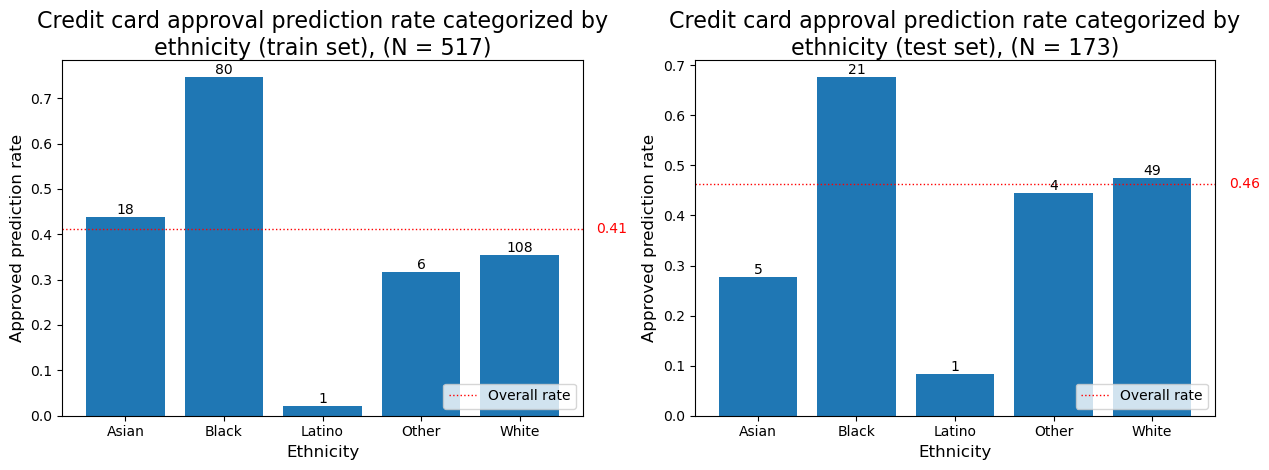

In [23]:
credit_y_train_pred = credit_gnb_gs.predict(credit_X_train)

sensitive_rate_plots(
    [credit_X_train['Ethnicity'], credit_X_test['Ethnicity']],
    [pd.Series(credit_y_train_pred, name='Approved prediction'), pd.Series(credit_y_test_pred, name='Approved prediction')],
    [1, 1],
    ['Credit card approval prediction rate categorized by ethnicity (train set)', 'Credit card approval prediction rate categorized by ethnicity (test set)']
)

In [24]:
dep_latino_train = fairness_dependence_metric(
    credit_X_train['Ethnicity'],
    credit_y_train_pred,
    'Latino',
    1
)

dep_latino_test = fairness_dependence_metric(
    credit_X_test['Ethnicity'],
    credit_y_test_pred,
    'Latino',
    1
)

print(f'DEP on train: {dep_latino_train:.2f}; DEP on test: {dep_latino_test:.2f}')

DEP on train: 0.43; DEP on test: 0.41


The plots indicate the model is not fair with respect to statistical parity. The dependence metric reflects this bad fairness. It is as bad (and worse on the training data) than the initial dataset.

## Fairness through reweighing
In this section we attempt to make the previous predictive model satisfy statistical parity. Calders et al. (2009) proposed two methods of doing so. **Massaging** reduces the dependency by changing the target feature in the dataset. Admittedly, this is intrusive. The **reweighing** approach associates weights to each combination of target classes with protected or non-protected groups. Reweighing is considered a preprocessing fairness method, but the weights are used during training. We will use the reweighing approach, as Gaussian naive Bayes supports weighted samples and because it leaves the original predictions unchanged.

### Preprocessing
We first start by constructing a modification to the preprocessing transformer. It no longer allows for ethnicity to be used in the model.

In [25]:
# keep same feature transformer, only drop ethnicity
credit_nominal_rw = ['Industry', 'Citizen']
credit_nom_rw = (
    'encode_nominals',
    OneHotEncoder( # create dummy features
        categories=[  # set explicit categories, necessary for ROC later on
            credit_df[feat].unique()
            for feat in credit_nominal_rw
        ],
        sparse_output=False # necessary for ROC later on
    ),
    credit_nominal_rw,
)
credit_ctf_rw = ColumnTransformer(
    transformers=[credit_nom_rw, credit_std, credit_pass],
    remainder='drop'
)

Next, the weights for each sample is calculated. The following formula was derived from Calders et al. (2009), each sample $\vec{x} \in X$ with sensitive feature $S = s$ and target value $Y = y$ has weight:
$$W_{s, y} = \frac {|\{\vec{z} \in X \mid \vec{z}(S) = s\}|*|\{\vec{z} \in X \mid \vec{z}(Y) = y\}|} {|\{\vec{z} \in X \mid \vec{z}(S) = s, \vec{z}(Y) = y\}|*|X|}$$

In [26]:
def dependence_weights(df_x, df_y, protected_group, positive):
    prot_mask = df_x == protected_group
    pos_mask = df_y == positive

    n = len(df_y)
    
    n_prot = prot_mask.sum()
    n_pos = pos_mask.sum()
    n_nprot = n - prot_mask.sum()
    n_npos = n - pos_mask.sum()

    n_prot_pos = (prot_mask & pos_mask).sum()
    n_prot_npos = (prot_mask & ~pos_mask).sum()
    n_nprot_pos = (~prot_mask & pos_mask).sum()
    n_nprot_npos = (~prot_mask & ~pos_mask).sum()

    weights = np.ones(n)

    weights[prot_mask & pos_mask] = (n_prot * n_pos) / (n_prot_pos * n)
    weights[prot_mask & ~pos_mask] = (n_prot * n_npos) / (n_prot_npos * n)
    weights[~prot_mask & pos_mask] = (n_nprot * n_pos) / (n_nprot_pos * n)
    weights[~prot_mask & ~pos_mask] = (n_nprot * n_npos) / (n_nprot_npos * n)
    
    return weights

In [27]:
credit_weights = dependence_weights(
    credit_X_train['Ethnicity'],
    credit_y_train,
    'Latino',
    1
)

np.unique(credit_weights)

array([0.62451644, 0.93324737, 1.06080705, 4.00386847])

### Model fitting and hyperparameter search
The Gaussian Naive Bayes is fitted with the training data and weights. This is the same as before, but we make sure to use preprocessing that excludes the ethnicity attribute and include the sample weights.

In [28]:
# pipeline with preprocessing and Gaussian naive Bayes
credit_pipe_rw = Pipeline([
    ('col_trans', credit_ctf_rw), # transformer without ethnicity
    ('k_best', credit_skb),
    ('gnb', GaussianNB())
])

# grid search for best parameters
credit_gnb_gs_rw = GridSearchCV(
    credit_pipe_rw, 
    credit_params,
    scoring='accuracy',
    n_jobs=-1,
    refit=True,
    cv=credit_kfcv,
    return_train_score=True
)

# fit using sample weights and print best params
credit_gnb_gs_rw.fit(
    credit_X_train, 
    credit_y_train,
    gnb__sample_weight=credit_weights
)
for param, value in credit_gnb_gs_rw.best_params_.items():
    print(f'{param}: {value}')

k_best__k: 18


### Model performance and fairness assessment

In [29]:
credit_y_test_pred_rw = credit_gnb_gs_rw.predict(credit_X_test)
score_summary(credit_y_test_pred_rw, credit_y_test)

R^2: 0.26; MAE: 0.18; MSE: 0.18


The fitted model has an accuracy of prediction is $1-\operatorname{MAE} = 0.82$. This means the accuracy only went down by $5%$. The loss in performance on the test set is not inherently bad. A fair model that always predicts correctly and fairly will not perform as good on a biased dataset as an unfair model (which potentially overfits) on the dataset. With fairness in mind, one has to look at both performance and fairness. So next, we look at the predicted rates by ethnicity again and calculate the dependence using the $\operatorname{dep}_{E = \mathrm{Latino}}$ metric.

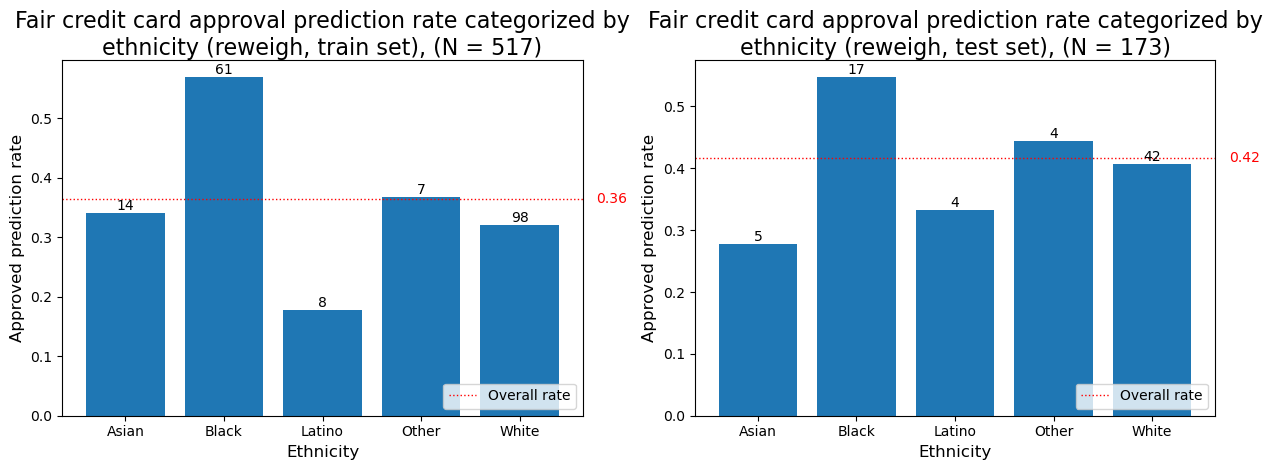

In [30]:
credit_y_train_pred_rw = credit_gnb_gs_rw.predict(credit_X_train)

sensitive_rate_plots(
    [credit_X_train['Ethnicity'], credit_X_test['Ethnicity']],
    [pd.Series(credit_y_train_pred_rw, name='Approved prediction'), pd.Series(credit_y_test_pred_rw, name='Approved prediction')],
    [1, 1],
    ['Fair credit card approval prediction rate categorized by ethnicity (reweigh, train set)', 'Fair credit card approval prediction rate categorized by ethnicity (reweigh, test set)']
)

In [31]:
dep_latino_train_rw = fairness_dependence_metric(
    credit_X_train['Ethnicity'],
    credit_y_train_pred_rw,
    'Latino',
    1
)

dep_latino_test_rw = fairness_dependence_metric(
    credit_X_test['Ethnicity'],
    credit_y_test_pred_rw,
    'Latino',
    1
)

print(f'DEP on train: {dep_latino_train_rw:.2f}; DEP on test: {dep_latino_test_rw:.2f}')

DEP on train: 0.20; DEP on test: 0.09


The plots indicate much better fairness for the protected group. The dependence metric confirms this result: it is a fourth of the initial (unfair) model.

## Fairness through Reject Option based Classification
The final improvement to the classifier involves postprocessing using **Reject Option based Classification** (ROC). Essentially, it is a method that favors the outcome of the protected group, while giving unfavorable outcomes to the other. It does this for samples close to decision boundaries (so-called *critical region*). Formally, it looks at the posterior probability of a sample. The uncertainty of its probability of classification will decide if the sample should get another classification based on a threshold with a margin (Kamiran & et al., 2012).

### Model fit and hyperparameter search
We keep the preprocessing from the previous model. We use the Scikit-learn compatible module `aif360` that implements ROC. It performs a grid search for the best threshold and margin with respect to the dependence metric.

In [32]:
# RejectOptionClassifier expects index by sensitive feature, with default 0 for the protected group
credit_i_train_roc = pd.Index(credit_X_train['Ethnicity'] != 'Latino', dtype=int, name='LatinoEthnicity')
credit_X_train.index = credit_i_train_roc
credit_y_train.index = credit_i_train_roc

# get k-best from previous result
credit_skb_roc = SelectKBest(k=credit_gnb_gs_rw.best_params_['k_best__k'])

# pipeline with preprocessing, Gaussian naive Bayes and ROC postprocessing
# uses wrapper that splits traing set into sets for estimator and postprocessor to prevent information leakage
credit_ppm_roc = PostProcessingMeta(
    Pipeline([
        ('col_trans', credit_ctf_rw),
        ('k_best', credit_skb),
        ('gnb', GaussianNB())
    ]).set_output(transform='pandas'),
    RejectOptionClassifierCV( # GridSearchCV equivalent for ROC, finds best margin and threshold
        'LatinoEthnicity',
        scoring='statistical_parity', # statistical parity scoring metric similar to dependence metric
        step=0.05,
        cv=credit_kfcv,
        n_jobs=-1,
        refit=True,
        return_train_score=True
    ),
    random_state=0
)

# fit using sample weights and print best params
credit_ppm_roc.fit(
    credit_X_train, 
    credit_y_train,
    # gnb__sample_weight=credit_weights
)
for param, value in credit_ppm_roc.postprocessor_.best_params_.items():
    print(f'postprocessor__{param}: {value}')

postprocessor__margin: 0.44999999999999996
postprocessor__prot_attr: LatinoEthnicity
postprocessor__threshold: 0.55


### Model performance and fairness assessment

In [33]:
credit_i_test_roc = pd.Index(credit_X_test['Ethnicity'] != 'Latino', dtype=int, name='LatinoEthnicity')
credit_X_test.index = credit_i_test_roc

credit_y_test_pred_roc = credit_ppm_roc.predict(credit_X_test)
score_summary(credit_y_test_pred_roc, credit_y_test)

R^2: -6.97; MAE: 0.39; MSE: 0.39


The model performance has drastically decreased to an accuracy. The negative $R^2$ value indicates the model performs worse than the mean target values. We plot the predicted rates and calculate the dependence one last time.

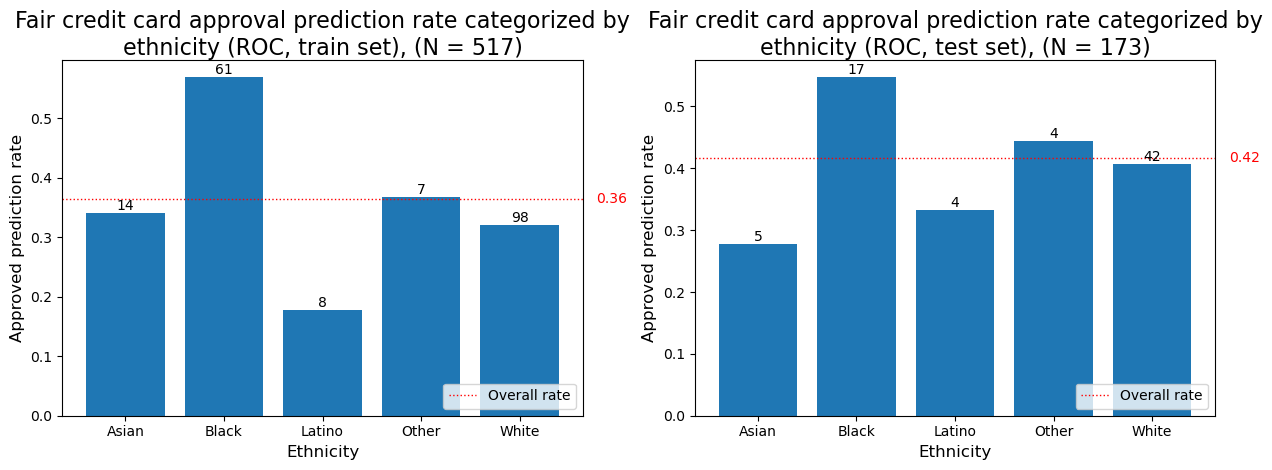

In [34]:
credit_y_train_pred_roc = credit_ppm_roc.predict(credit_X_train)

sensitive_rate_plots(
    [credit_X_train['Ethnicity'], credit_X_test['Ethnicity']],
    [pd.Series(credit_y_train_pred_rw, name='Approved prediction'), pd.Series(credit_y_test_pred_rw, name='Approved prediction')],
    [1, 1],
    ['Fair credit card approval prediction rate categorized by ethnicity (ROC, train set)', 'Fair credit card approval prediction rate categorized by ethnicity (ROC, test set)']
)

In [35]:
dep_latino_train_roc = fairness_dependence_metric(
    credit_X_train['Ethnicity'],
    credit_y_train_pred_roc,
    'Latino',
    1
)

dep_latino_test_roc = fairness_dependence_metric(
    credit_X_test['Ethnicity'],
    credit_y_test_pred_roc,
    'Latino',
    1
)

print(f'DEP on train: {dep_latino_train_roc:.2f}; DEP on test: {dep_latino_test_roc:.2f}')

DEP on train: -0.01; DEP on test: -0.12


The dependence is nearly completely gone. It has even shifted in favor of the protected group. But, at a significant performance penalty. This is due to the relatively high threshold and margin obtained from the grid search. To conclude, we visualize the performance and fairness trade-off governed by the threshold and margin.

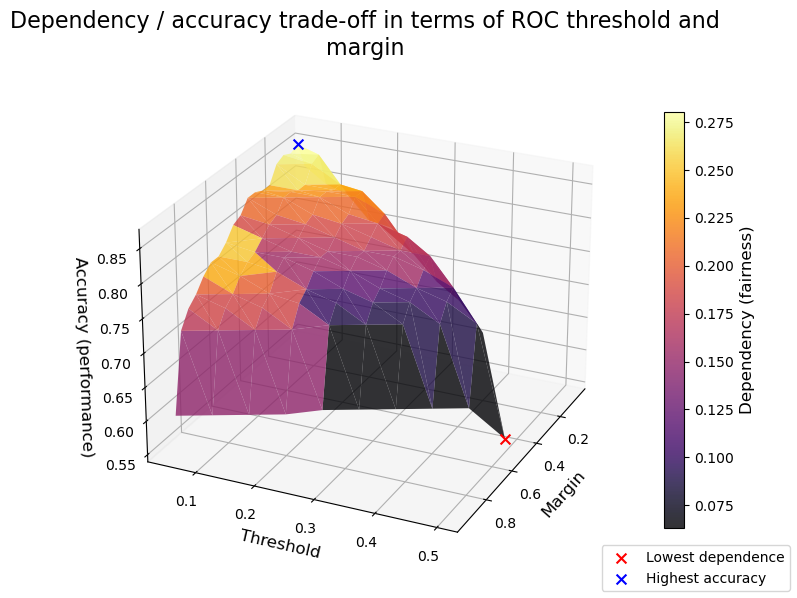

In [39]:
# get grid search threshold and margin values
credit_roc_pp = credit_ppm_roc.postprocessor_
credit_roc_res = pd.DataFrame(credit_roc_pp.cv_results_)
credit_roc_t = credit_roc_res['param_threshold']
credit_roc_m = credit_roc_res['param_margin']

# ROC postprocessing without grid search
credit_ppm_trade = PostProcessingMeta(
    credit_ppm_roc.estimator,
    RejectOptionClassifier('LatinoEthnicity'),
    random_state=0
).fit(credit_X_train, credit_y_train)

# dependency and accuracy results
credit_roc_dep = np.zeros(credit_roc_t.shape)
credit_roc_acc = np.zeros(credit_roc_t.shape)

# fit, predict and score for each threshold and margin
for i, (t, m) in enumerate(zip(credit_roc_t, credit_roc_m)):
    credit_ppm_trade.set_params(
        postprocessor__threshold=t,
        postprocessor__margin=m
    )
    y_pred = credit_ppm_trade.fit(credit_X_train, credit_y_train).predict(credit_X_test)
    credit_roc_dep[i] = fairness_dependence_metric(credit_X_test['Ethnicity'], y_pred, 'Latino', 1)
    credit_roc_acc[i] = 1 - mean_absolute_error(credit_y_test, y_pred)

# best dependency and accuracy
credit_roc_dep_best_i = np.argmin(credit_roc_dep)
credit_roc_acc_best_i = np.argmax(credit_roc_acc)


fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(projection='3d', computed_zorder=False))

# 4D triangulated plot
trisurf = ax.plot_trisurf(
    credit_roc_t,
    credit_roc_m,
    credit_roc_acc,
    cmap='inferno',
    alpha=0.8,
    zorder=1
)

# get colors
triangles = tri.Triangulation(
    credit_roc_t,
    credit_roc_m
).triangles
colors = credit_roc_dep.take(triangles).max(axis=1)
trisurf.set_array(colors)

# color bar
cbar = fig.colorbar(trisurf, shrink=0.8)
cbar.set_label('Dependency (fairness)', fontsize=12)

# best dependency
ax.scatter(
    credit_roc_t[credit_roc_dep_best_i],
    credit_roc_m[credit_roc_dep_best_i],
    credit_roc_acc[credit_roc_dep_best_i],
    c='r',
    s=50,
    marker='x',
    label='Lowest dependence',
    zorder=2
)
# best performance
ax.scatter(
    credit_roc_t[credit_roc_acc_best_i],
    credit_roc_m[credit_roc_acc_best_i],
    credit_roc_acc[credit_roc_acc_best_i],
    c='b',
    s=50,
    marker='x',
    label='Highest accuracy',
    zorder=2
)

# axes indicators and more
ax.set_xlabel('Margin', fontsize=12)
ax.set_ylabel('Threshold', fontsize=12)
ax.set_zlabel('Accuracy (performance)', fontsize=12)
ax.set_title('Dependency / accuracy trade-off in terms of ROC threshold and margin', fontsize=16, wrap=True)
fig.legend(loc='lower right')

fig.tight_layout()
ax.view_init(elev=25, azim=25)

## Further improvements to fairness
The final model yields complete independence between the protected ethnicity group and credit card approval. Admittedly, at a severe performance penalt. Also, it might introduce unfairness in other regards. In fact. From the predicted approval rate plots it seems that Asians got penalized the most. Black people still seem to be favored, just as in the initial dataset. This might not be desirable. It raises an important problem with the statistical parity fairness notion. Striving for equal opportunities with this notion does not require the best of the (non-)protected subgroups. While maximizing overall performance does influence this, it does not take into account how accurate each group is represented. As a result, Dwork et al. (2012) concluded that statistical parity is not sufficient as a fairness notion. Instead, a more appropriate fairness notion than statistical parity: **fairness through awareness**. As opposed to statistical parity, fairness through awareness is an individual fairness notions: it does not look at a sensitive property in particular. Individual fairness is satisfied when similar individuals are classified similarly, in proportion to their degree of similarity (Dwork et al. 2012).

## Conclusion
In this work, we introduced fairness and the notion of statistical parity. The dependence metric was used to quantify statistical parity fairness. We looked at bad and good methods of improving fairness with respect to statistical parity. From our empirical results, we conclude that statistical parity can be satisfied with very little performance penalty. However, recent literature is moving towards individual fairness, as group fairness notions are not always as fair as they should.

## References
* Agarwal, A., Dudík, M., & Wu, Z. S. (2019, May). Fair regression: Quantitative definitions and reduction-based algorithms. In *International Conference on Machine Learning (pp. 120-129)*. PMLR.
* Barocas, S., Hardt, M., & Narayanan, A. (2017). Fairness in machine learning. Nips tutorial, 1, 2017.
* Calders, T., Kamiran, F., & Pechenizkiy, M. (2009, December). Building classifiers with independency constraints. In *2009 IEEE international conference on data mining workshops* (pp. 13-18). IEEE.
* Chouldechova, A., & Roth, A. (2018). The frontiers of fairness in machine learning. *arXiv preprint arXiv:1810.08810*.
* Chzhen, E. (2022). *Algorithmic Fairness : regression with demographic parity constraints* (slides) [https://www.dataia.eu/sites/default/files/Documents/Chzhen_slides22June.pdf].
* Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.
* Dwork, C., Hardt, M., Pitassi, T., Reingold, O., & Zemel, R. (2012, January). Fairness through awareness. In *Proceedings of the 3rd innovations in theoretical computer science conference* (pp. 214-226).
* Kamiran, F., Karim, A., & Zhang, X. (2012, December). Decision theory for discrimination-aware classification. In *2012 IEEE 12th international conference on data mining (pp. 924-929)*. IEEE.
* Pace, R. Kelley and Ronald Barry, Sparse Spatial Autoregressions, Statistics and Probability Letters, 33 (1997) 291-297.